In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from data_preprocessing import detect_outliers, plot_outliers, handle_outliers

In [5]:
tickers = ['AAPL', 'GOOGL', 'IBM','AMZN']  
data = []
start_date='2020-01-01'
end_date='2023-01-01'

aapl_data = yf.download('AAPL', start=start_date, end=end_date)
googl_data = yf.download('GOOGL', start=start_date, end=end_date)
IBM_data = yf.download('IBM', start=start_date, end=end_date)
amzn_data = yf.download('AMZN', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


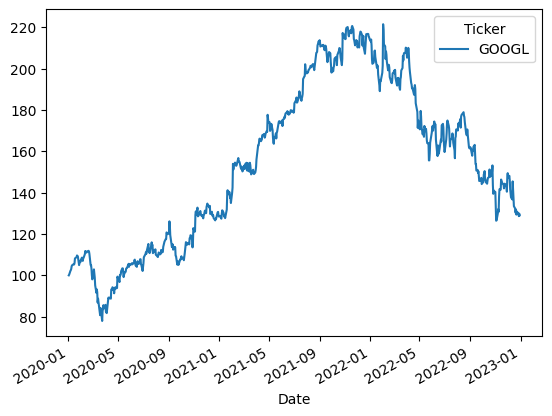

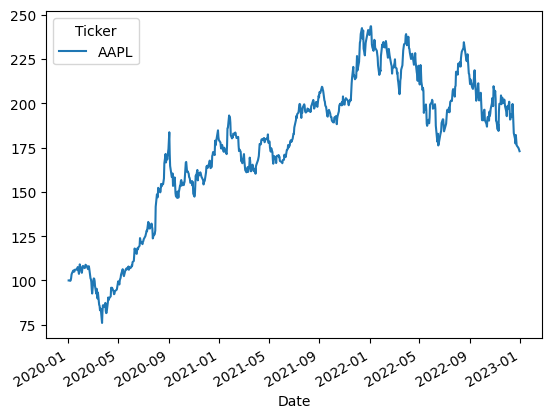

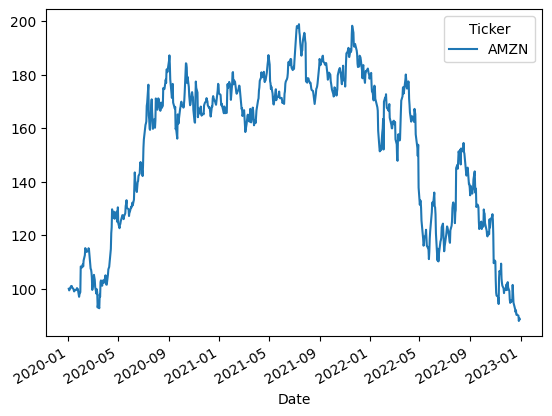

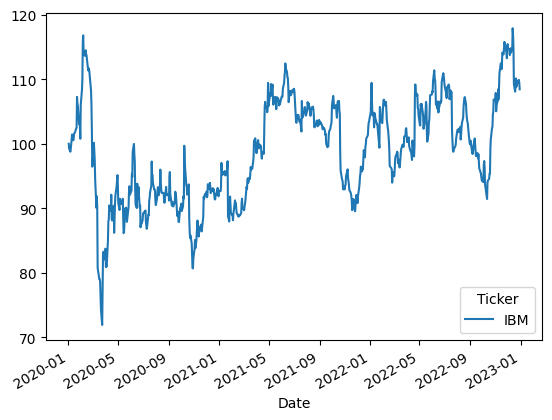

In [6]:
# Normalizing and comparison
# Both stocks start from 100
import matplotlib.pyplot as plt
normalized_google = googl_data.High.div(googl_data.High.iloc[0]).mul(100)
normalized_apple = aapl_data.High.div(aapl_data.High.iloc[0]).mul(100)
normalized_amazon = amzn_data.High.div(amzn_data.High.iloc[0]).mul(100)
normalized_ibm = IBM_data.High.div(IBM_data.High.iloc[0]).mul(100)
normalized_google.plot()
normalized_apple.plot()
normalized_amazon.plot()
normalized_ibm.plot()
plt.show()


Analyzing outliers for Apple:

Outlier Statistics:

('Adj Close', 'AAPL'):
Number of outliers: 7
Lower bound: 59.58
Upper bound: 201.98

('Close', 'AAPL'):
Number of outliers: 13
Lower bound: 63.29
Upper bound: 203.15

('High', 'AAPL'):
Number of outliers: 14
Lower bound: 65.33
Upper bound: 203.84

('Low', 'AAPL'):
Number of outliers: 13
Lower bound: 61.78
Upper bound: 201.38

('Open', 'AAPL'):
Number of outliers: 18
Lower bound: 64.42
Upper bound: 201.76

('Volume', 'AAPL'):
Number of outliers: 41
Lower bound: -3537300.00
Upper bound: 209534700.00

Generating box plots...


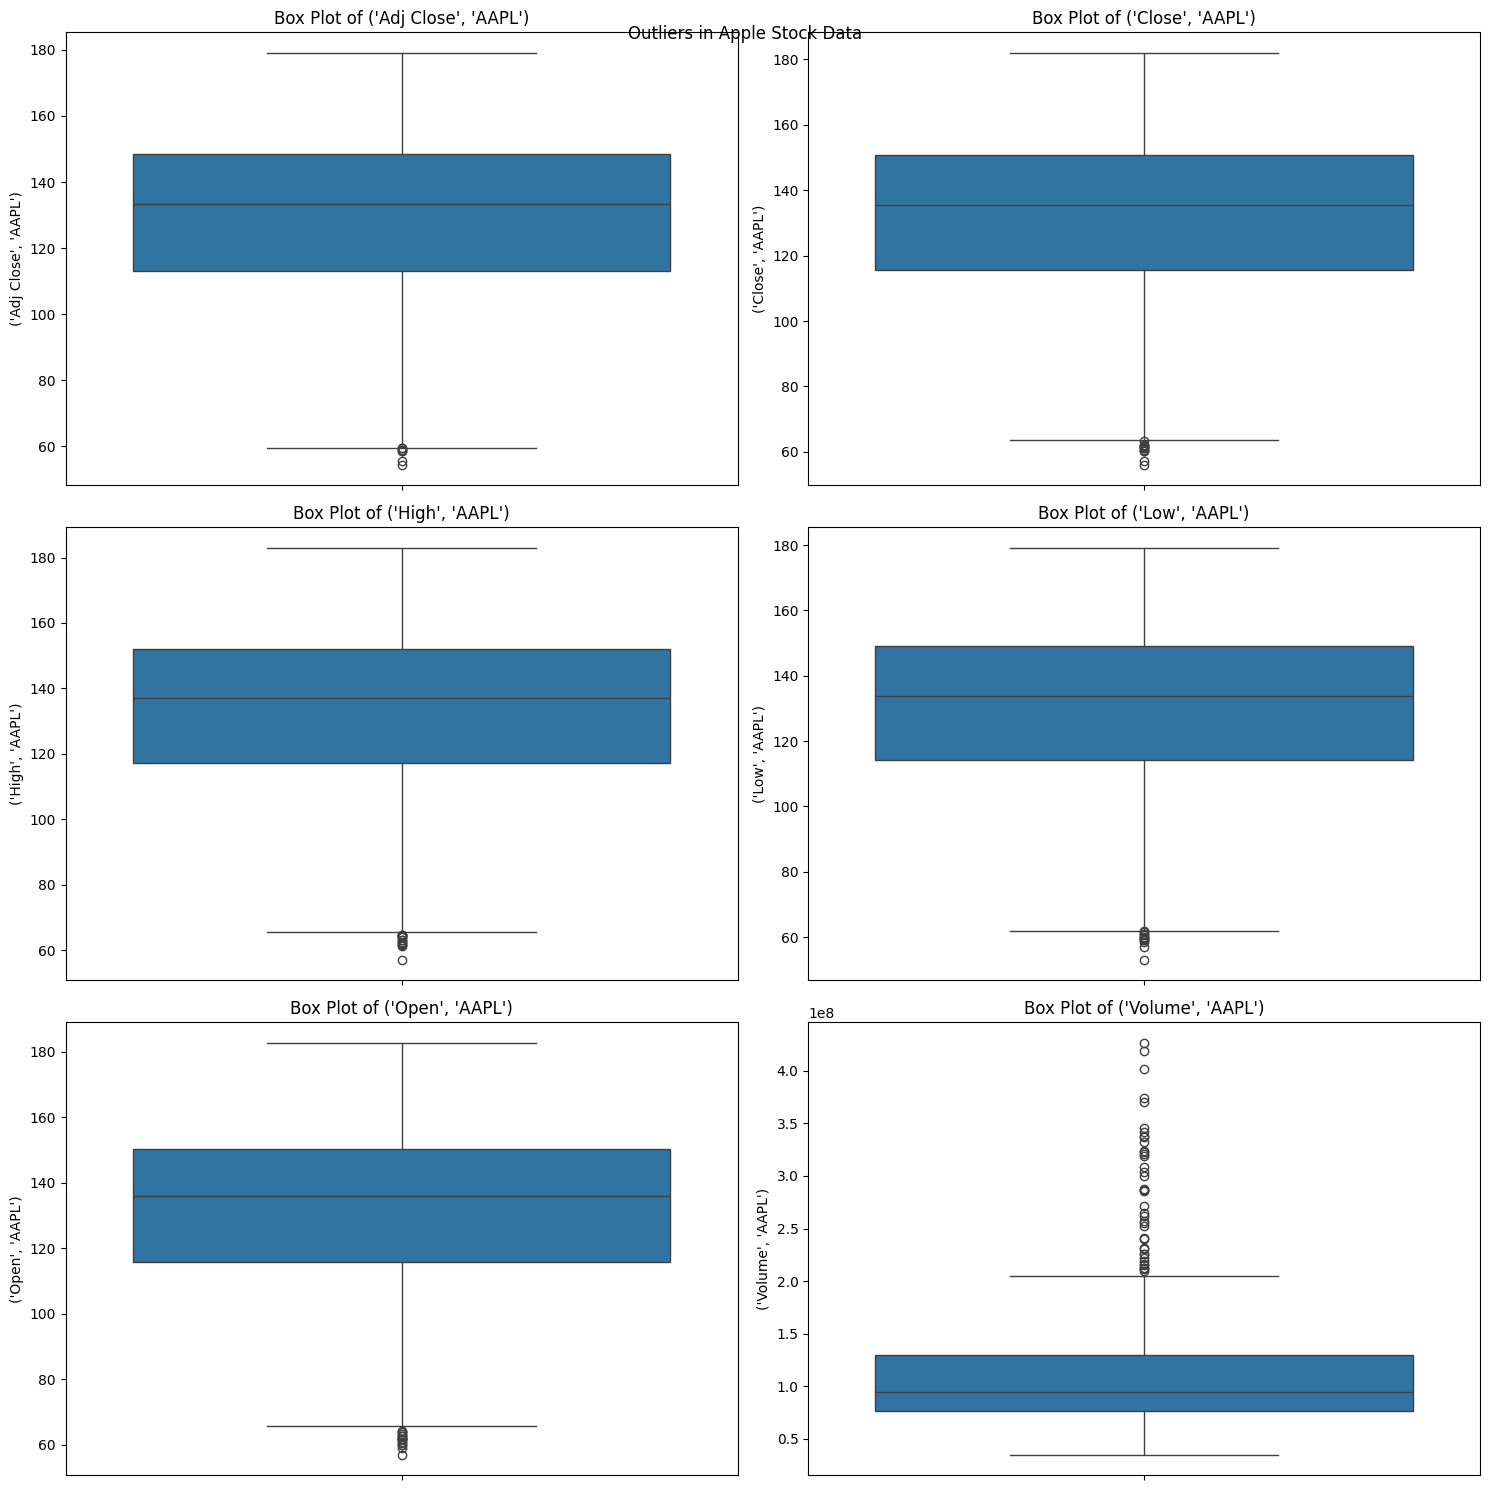


Handling outliers...

Outlier Count Comparison (Before -> After):
('Adj Close', 'AAPL'): 7 -> 0
('Close', 'AAPL'): 13 -> 0
('High', 'AAPL'): 14 -> 0
('Low', 'AAPL'): 13 -> 0
('Open', 'AAPL'): 18 -> 0
('Volume', 'AAPL'): 41 -> 0


In [7]:
print(f"\nAnalyzing outliers for Apple:")
# Detect outliers using IQR method
outliers = detect_outliers(aapl_data, method='iqr', threshold=1.5)
# Print outlier statistics
print("\nOutlier Statistics:")
for column, stats in outliers.items():
    print(f"\n{column}:")
    print(f"Number of outliers: {stats['outlier_count']}")
    if 'lower_bound' in stats:
        print(f"Lower bound: {stats['lower_bound']:.2f}")
        print(f"Upper bound: {stats['upper_bound']:.2f}")
# Visualize outliers using box plots
print("\nGenerating box plots...")
plot_outliers(aapl_data)
plt.suptitle(f'Outliers in Apple Stock Data')
plt.show()

# Handle outliers using clipping method
print("\nHandling outliers...")
aapl_data = handle_outliers(aapl_data, method='clip')
# Verify outlier handling
outliers_after = detect_outliers(aapl_data, method='iqr', threshold=1.5)
    
# Compare before and after
print("\nOutlier Count Comparison (Before -> After):")
for column in outliers.keys():
        before_count = outliers[column]['outlier_count']
        after_count = outliers_after[column]['outlier_count']
        print(f"{column}: {before_count} -> {after_count}")

Analyzin Outliers for the IBM Stock Data

('Adj Close', 'IBM')
 Number of Outliers : 0
 Lower Bound : 69.64
 Upper Bound : 146.58

('Close', 'IBM')
 Number of Outliers : 2
 Lower Bound : 93.77
 Upper Bound : 160.68

('High', 'IBM')
 Number of Outliers : 1
 Lower Bound : 94.33
 Upper Bound : 162.73

('Low', 'IBM')
 Number of Outliers : 3
 Lower Bound : 92.79
 Upper Bound : 159.64

('Open', 'IBM')
 Number of Outliers : 1
 Lower Bound : 93.49
 Upper Bound : 160.79

('Volume', 'IBM')
 Number of Outliers : 52
 Lower Bound : 376201.38
 Upper Bound : 9340508.38

 Plotting Outliers


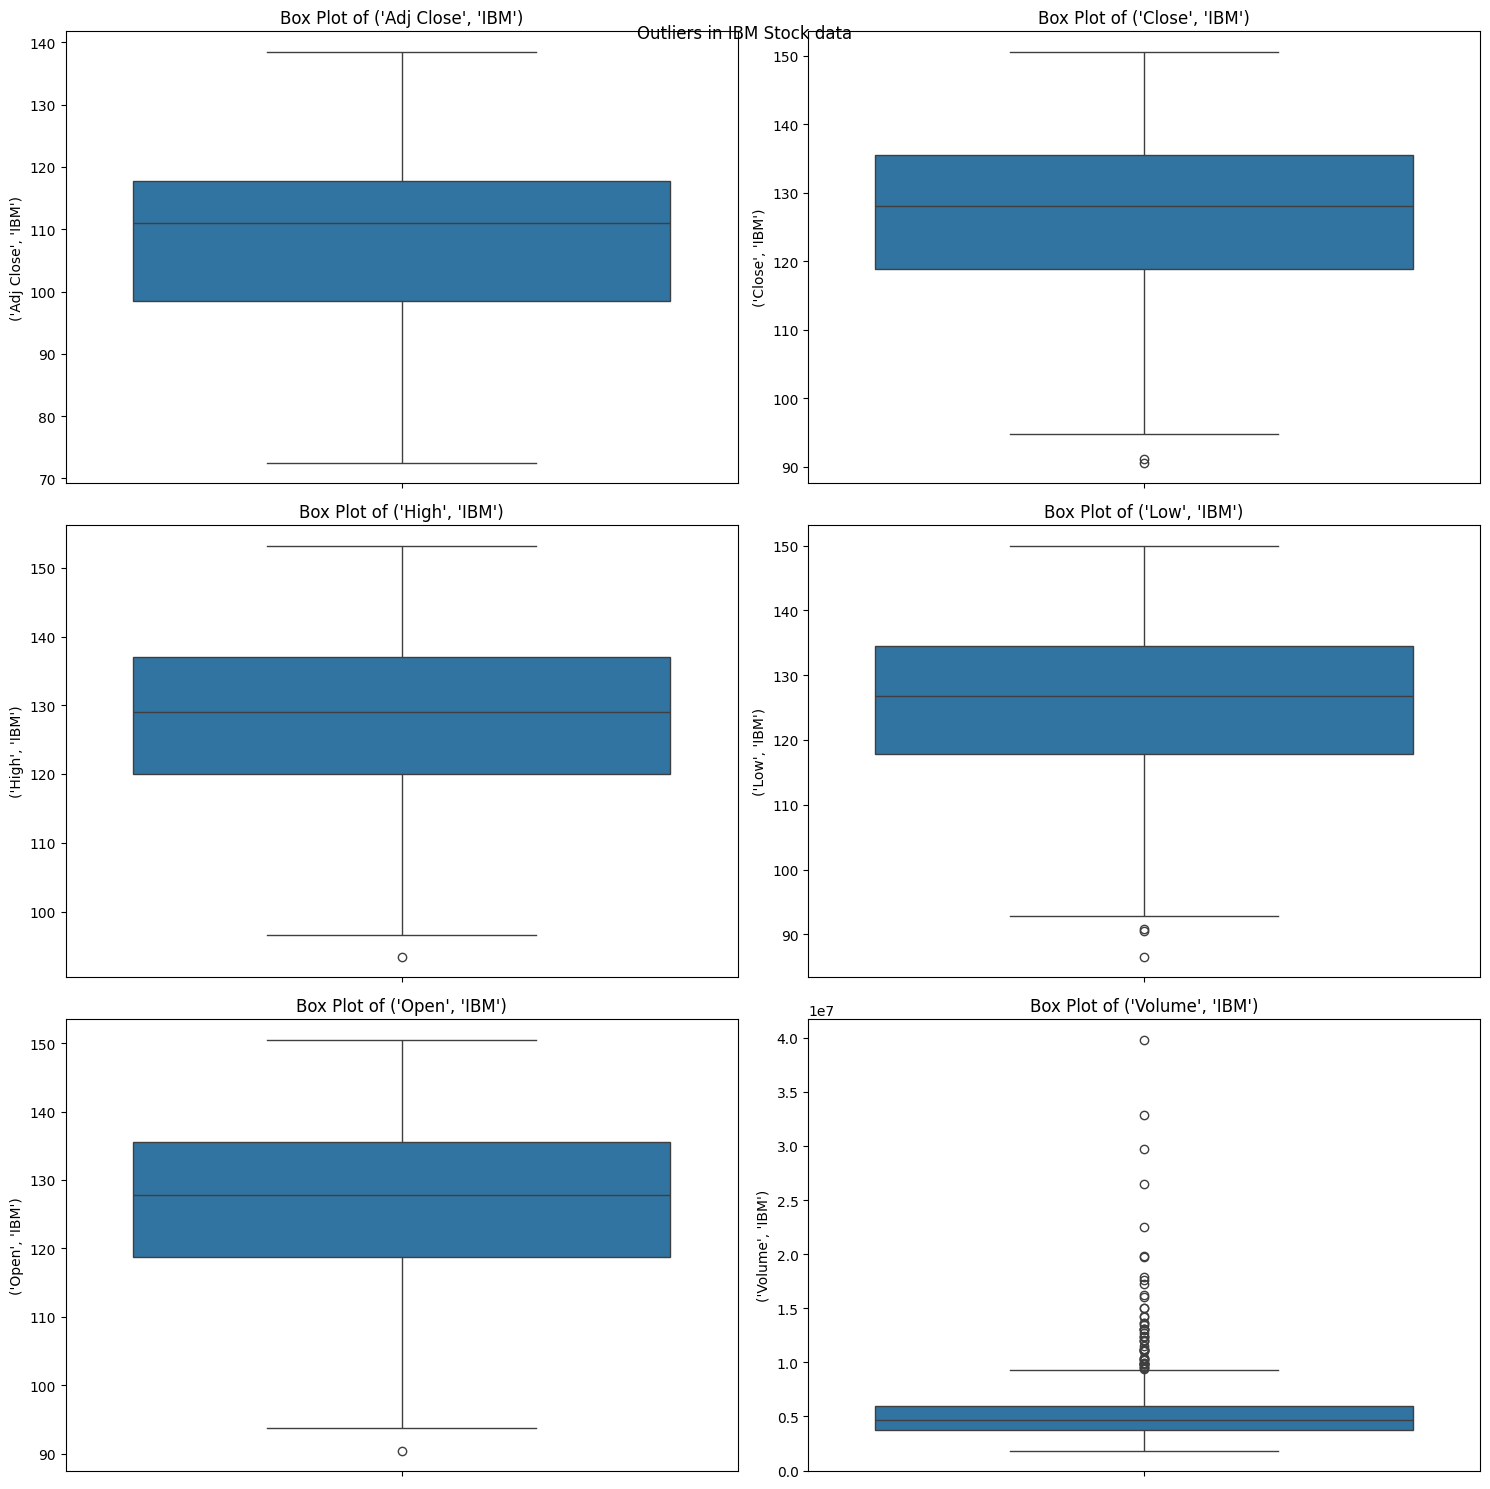


 Handling Outliers

Outlier Count Comparison (Before -> After):
('Adj Close', 'IBM'): 0 -> 0
('Close', 'IBM'): 2 -> 0
('High', 'IBM'): 1 -> 0
('Low', 'IBM'): 3 -> 0
('Open', 'IBM'): 1 -> 0
('Volume', 'IBM'): 52 -> 0


In [8]:
print("Analyzin Outliers for the IBM Stock Data")
outliers=detect_outliers(IBM_data,method='iqr',threshold=1.5)
for column,stats in outliers.items():
    print(f"\n{column}")
    print(f" Number of Outliers : {stats['outlier_count']}")
    if 'lower_bound' in stats:
        print(f" Lower Bound : {stats['lower_bound']:.2f}")
        print(f" Upper Bound : {stats['upper_bound']:.2f}")
print("\n Plotting Outliers")
plot_outliers(IBM_data)
plt.suptitle("Outliers in IBM Stock data")
plt.show()
print("\n Handling Outliers")
IBM_data=handle_outliers(IBM_data,method='clip')
outliers_after=detect_outliers(IBM_data,method='iqr',threshold=1.5)
print("\nOutlier Count Comparison (Before -> After):")
for column in outliers.keys():
        before_count = outliers[column]['outlier_count']
        after_count = outliers_after[column]['outlier_count']
        print(f"{column}: {before_count} -> {after_count}")



 Outlier Analysis of Amazon Stock Data
('Adj Close', 'AMZN')
No of Outliers : 0
Lower Bound 48.89
Upper Bound 234.08
('Close', 'AMZN')
No of Outliers : 0
Lower Bound 48.89
Upper Bound 234.08
('High', 'AMZN')
No of Outliers : 0
Lower Bound 49.73
Upper Bound 236.25
('Low', 'AMZN')
No of Outliers : 0
Lower Bound 45.75
Upper Bound 233.28
('Open', 'AMZN')
No of Outliers : 0
Lower Bound 48.86
Upper Bound 234.31
('Volume', 'AMZN')
No of Outliers : 35
Lower Bound 170750.00
Upper Bound 151944750.00
Plot Outliers


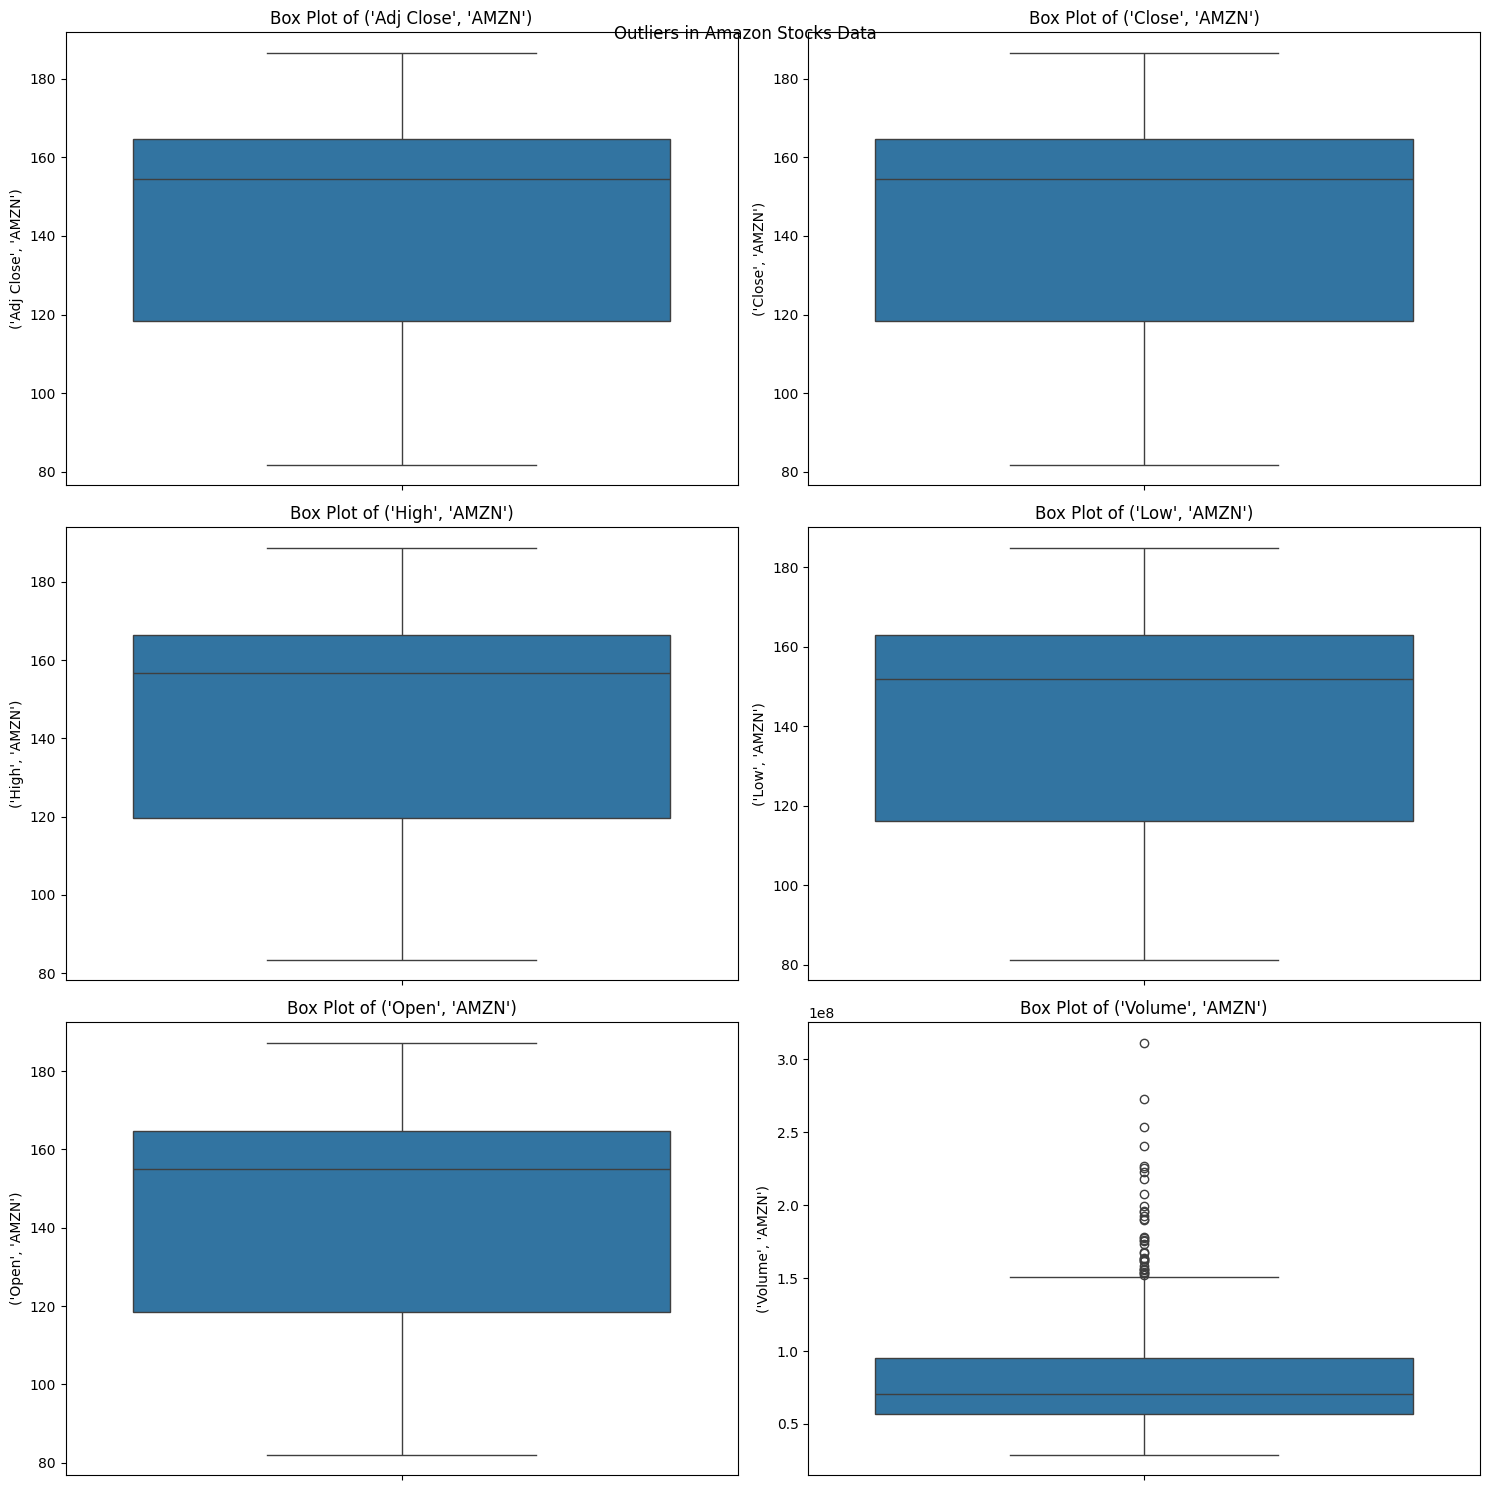


 handling Outliers...
Comparing Outliers (Before -> After)
('Adj Close', 'AMZN') 0->0
('Close', 'AMZN') 0->0
('High', 'AMZN') 0->0
('Low', 'AMZN') 0->0
('Open', 'AMZN') 0->0
('Volume', 'AMZN') 35->0


In [9]:
print("\n Outlier Analysis of Amazon Stock Data")
outliers=detect_outliers(amzn_data,method='iqr',threshold=1.5)
for column,stats in outliers.items():
    print(f"{column}")
    print(f"No of Outliers : {stats['outlier_count']}")
    if 'lower_bound' in stats:
        print(f"Lower Bound {stats['lower_bound']:.2f}")
        print(f"Upper Bound {stats['upper_bound']:.2f}")
print("Plot Outliers")
plot_outliers(amzn_data)
plt.suptitle('Outliers in Amazon Stocks Data')
plt.show()
print("\n handling Outliers...")
amzn_data=handle_outliers(amzn_data,method='clip')
outliers_after=detect_outliers(amzn_data,method='iqr',threshold=1.5)
print("Comparing Outliers (Before -> After)")
for column in outliers.keys():
    before_count=outliers[column]['outlier_count']
    after_count=outliers_after[column]['outlier_count']
    print(f"{column} {before_count}->{after_count}")


In [10]:
from data_preprocessing import predict_stock_prices_tft

In [11]:
# Example usage
results = predict_stock_prices_tft(
    aapl_data,  # Replace with your DataFrame
    target_col='Close',
    sequence_length=60,
    train_split=0.8,
    num_features=1,
    num_heads=1,
    d_model=32,
    num_layers=2,
    dropout=0.2
)

Processing data...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 2.2867 - val_loss: 2.3395
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5899 - val_loss: 1.4886
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1338 - val_loss: 0.9709
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9126 - val_loss: 0.6563
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6861 - val_loss: 0.4662
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4907 - val_loss: 0.3785
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4275 - val_loss: 0.3406
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4803 - val_loss: 0.3225
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3671 - val_loss: 0.3147
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4038 - val_loss: 0.3018
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3631 - val_loss: 0.2904
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s